# Yes/No 音声認識

ref. https://www.tensorflow.org/tutorials/audio/simple_audio  
ref. https://aidemy.net/magazine/661/  
ref. https://tips-memo.com/python-f0  

In [245]:
import sys
import pyaudio
import wave
import numpy as np
import pandas as pd
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import recorder
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
np.random.seed(seed)

In [10]:
# 録音して自分の声をyes/no各20サンプル作成(固定長)
n_datas = 20
samplerate = 16000
rec_seconds = 2
data_dir = "./data/yes_no_detection"

In [357]:
def record(filename_prefix):
    print("input start index or Enter to skip:")
    _input = input()
    if not _input:
        print("skip")
        return
    index = int(_input)
    print(index)
    while True:
        print("input Enter to rec or 'end' to end:")
        if input() == 'end':
            print("end")
            break
        rec = recorder.Recorder(channels=1, rate=samplerate)
        rec.record(rec_seconds, f'{data_dir}/{filename_prefix}{index}.wav')
        rec.close()
        index += 1
        print(f"next: {index}")

In [361]:
# 対話形式で生成
record("yes_")

input start index or Enter to skip:
skip


In [360]:
# 対話形式で生成
record("no_")

input start index or Enter to skip:
skip


In [13]:
# 録音ファイルをロード
X_no = []
X_yes = []
for i in range(n_datas):
    no, _ = librosa.load(f'{data_dir}/no_{i}.wav', sr=samplerate, mono=True)
    yes, _ = librosa.load(f'{data_dir}/yes_{i}.wav', sr=samplerate, mono=True)
    X_no.append(no)
    X_yes.append(yes)

## 特徴

In [14]:
print('Audio playback')
display.display(display.Audio(X_no[0], rate=samplerate))

Audio playback


### Waveform

In [79]:
def plot_samples(X, label):
    # case of n = 20
    rows = 4
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

    fig.suptitle(f"Waveform of '{label}'", fontsize=20)

    n = rows * cols
    t = np.arange(0, X[0].shape[0]/samplerate, 1/samplerate)
    for i, x in enumerate(X):
        r = i // cols
        c = i % cols
        ax = axes[r][c]
        ax.plot(t, x)
        ax.set_yticks(np.arange(-1.2, 1.2, 0.2))

        if i+1 >= n:
            break

    plt.show()
    

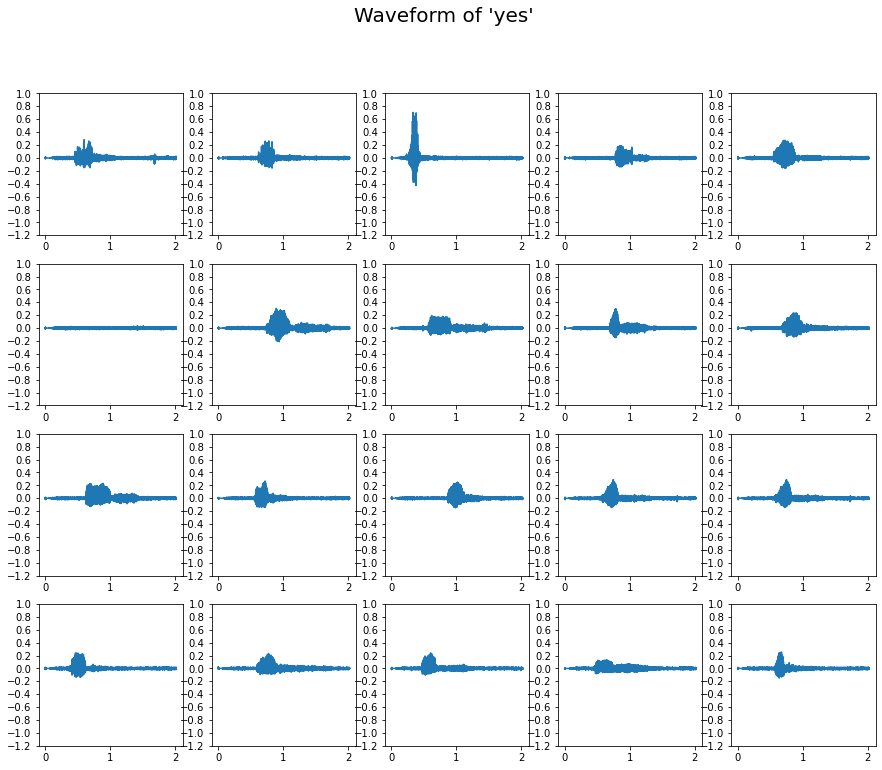

In [80]:
plot_samples(X_yes, "yes")

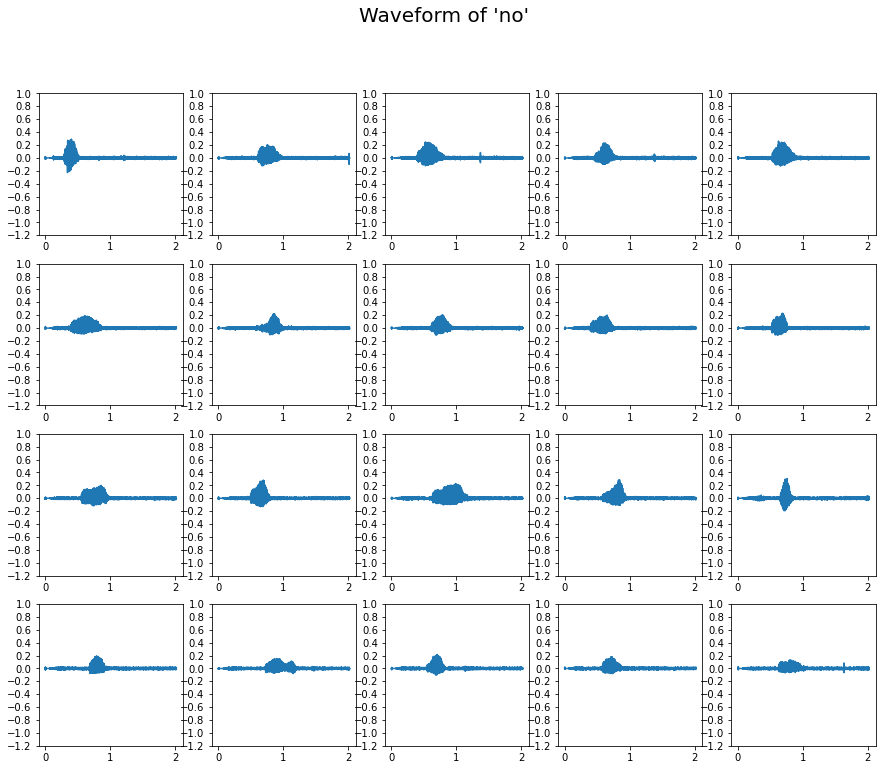

In [81]:
plot_samples(X_no, "no")

### Spectrogram

In [63]:
def get_log_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    f, t, Sxx = scipy.signal.stft(waveform, fs=samplerate)
    # Obtain the magnitude of the STFT.
    spectrogram = np.abs(Sxx)
    flouring = np.finfo(float).eps
    log_spectrogram = np.log(spectrogram + flouring)
    return f, t, log_spectrogram

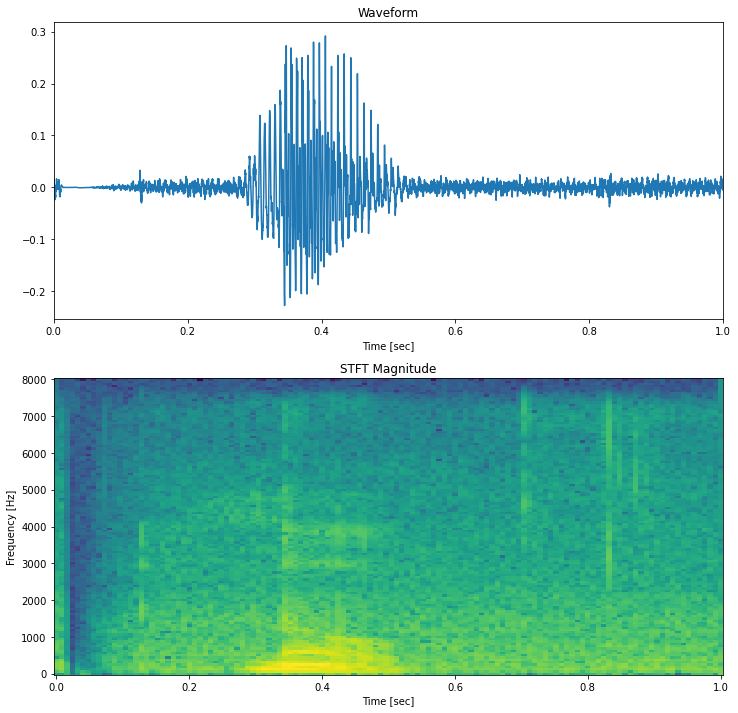

In [119]:
# len of samplerate = 1sec
target_length = samplerate
fig, axes = plt.subplots(2, figsize=(12, 12))

waveform = X_no[0][:target_length]
t = np.arange(0, waveform.shape[0]/samplerate, 1/samplerate)
axes[0].plot(t, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlabel('Time [sec]')
axes[0].set_xlim([0, target_length/samplerate]) # adjustment

f, t, log_spectrogram = get_log_spectrogram(waveform)
axes[1].pcolormesh(t, f, log_spectrogram)
axes[1].set_title('STFT Magnitude')
axes[1].set_xlabel('Time [sec]')
axes[1].set_ylabel('Frequency [Hz]')

plt.show()


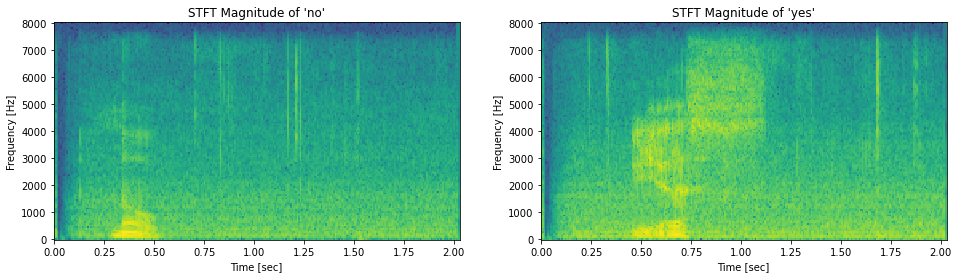

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

waveform_no = X_no[0]
f, t, log_spectrogram_no = get_log_spectrogram(waveform_no)
axes[0].pcolormesh(t, f, log_spectrogram_no)
axes[0].set_title("STFT Magnitude of 'no'")
axes[0].set_xlabel('Time [sec]')
axes[0].set_ylabel('Frequency [Hz]')

waveform_yes = X_yes[0]
f, t, log_spectrogram_yes = get_log_spectrogram(waveform_yes)
axes[1].pcolormesh(t, f, log_spectrogram_yes)
axes[1].set_title("STFT Magnitude of 'yes'")
axes[1].set_xlabel('Time [sec]')
axes[1].set_ylabel('Frequency [Hz]')

plt.show()

by librosa

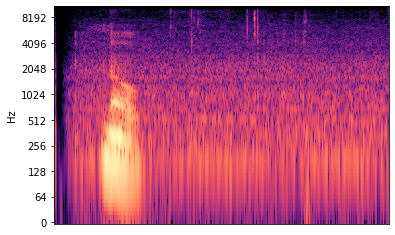

In [180]:
spec = librosa.stft(X_no[0], win_length=256)
spec_db = librosa.amplitude_to_db(np.abs(spec))
librosa.display.specshow(spec_db, y_axis="log")

### f0 score

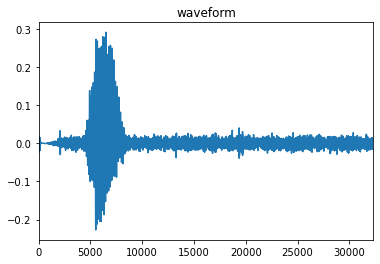

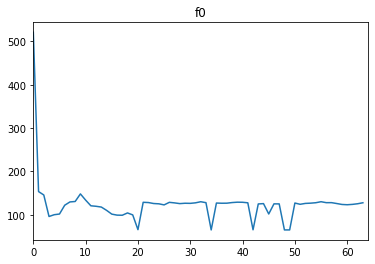

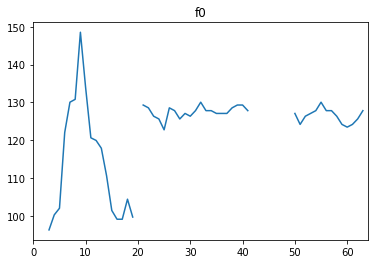

In [209]:
c2 = librosa.note_to_hz('C2')
c7 = librosa.note_to_hz('C7')

waveform = X_no[0]

plt.title("waveform")
plt.plot(waveform)
plt.xlim([0, len(waveform)]) # adjustment
plt.show()

f0 = librosa.yin(waveform, fmin=c2, fmax=c7, sr=samplerate)
plt.title("f0")
plt.plot(f0)
plt.xlim([0, len(f0)]) # adjustment
plt.show()

f0, _, _ = librosa.pyin(waveform, fmin=c2, fmax=c7, sr=samplerate)
plt.title("f0")
plt.plot(f0)
plt.xlim([0, len(f0)]) # adjustment
plt.show()

無音領域に不正値が入ってしまう

#### (補足) キレイな出力結果

In [197]:
!wget -P ./data https://tips-memo.com/wp-content/uploads/2019/12/adjust_doremi.wav

--2022-07-09 19:32:18--  https://tips-memo.com/wp-content/uploads/2019/12/adjust_doremi.wav
tips-memo.com (tips-memo.com) をDNSに問いあわせています... 183.90.237.57
tips-memo.com (tips-memo.com)|183.90.237.57|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 524346 (512K) [audio/x-wav]
`./data/adjust_doremi.wav.1' に保存中

adjust_doremi.wav.1 100%[===================>] 512.06K  --.-KB/s 時間 0.07s      

2022-07-09 19:32:18 (7.22 MB/s) - `./data/adjust_doremi.wav.1' へ保存完了 [524346/524346]



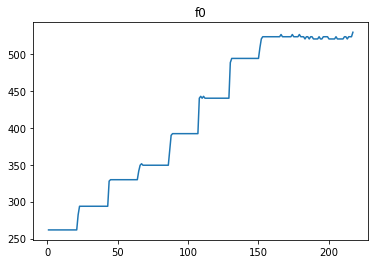

In [204]:
y, sr = librosa.load("data/adjust_doremi.wav")

f0, _, prob = librosa.pyin(y, fmin=c2, fmax=c7, sr=sr)

plt.title("f0")
plt.plot(f0)

plt.show()

### MFCC

ref. https://librosa.org/doc/main/generated/librosa.feature.mfcc.html#librosa.feature.mfcc

(20, 64)


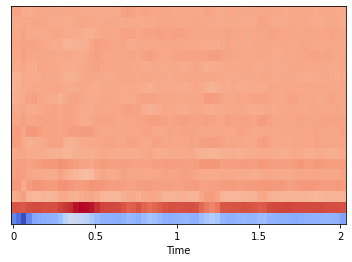

In [240]:
waveform = X_no[0]

# using S (reccomended)
S = librosa.feature.melspectrogram(y=waveform, sr=samplerate, n_mels=128,
                                   fmax=8000)
mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S))
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=samplerate, x_axis='time')

### Root Mean Square

ref. https://librosa.org/doc/main/generated/librosa.feature.rms.html#librosa.feature.rms

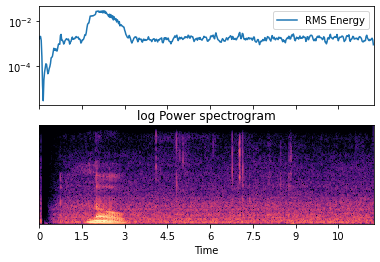

In [318]:
S = librosa.magphase(librosa.stft(X_no[0], win_length=256))[0]
rms = librosa.feature.rms(S=S)

fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                          x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')

plt.show()

## 推論

In [265]:
X = []
y = []
# noを0, yesを1に
names_by_label = {
    0: "no",
    1: "yes", 
}
for no, yes in zip(X_no, X_yes):
    X.append(no)
    y.append(0)
    X.append(yes)
    y.append(1)

In [232]:
# fftした絶対値と位相を特徴量とする
X_fft = np.array([np.fft.fft(x) for x in X])
X_feat = [np.hstack((x.real**2+x.imag**2, np.arctan2(x.real, x.imag))) for x in X_fft]

X_feat = np.array(X_feat)

### RandomForestClassifier

In [332]:
clf = sklearn.ensemble.RandomForestClassifier(random_state=seed)

scores = sklearn.model_selection.cross_val_score(clf, X_feat, y, cv=5)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

score:0.950 (+/-0.122)


#### 可視化
ref. https://yolo-kiyoshi.com/2021/02/13/post-2674/

In [333]:
def proximityMatrix(model, X, normalize=True):
    """
    近接行列を算出する

    Notes:
        https://stackoverflow.com/questions/18703136/proximity-matrix-in-sklearn-ensemble-randomforestclassifier
    """

    terminals = model.apply(X)
    data_size, nTrees = terminals.shape

    proxMat = np.zeros([data_size, data_size])

    for i in range(nTrees):
        belong_node = terminals[:, i]
        proxMat += 1*np.equal.outer(belong_node, belong_node)

    if normalize:
        proxMat = proxMat / nTrees

    return proxMat

clf = sklearn.ensemble.RandomForestClassifier(random_state=seed)
clf.fit(X_feat, y)

proximity_matrix = proximityMatrix(clf, X_feat, normalize=True)
print(f'proximity_matrix.shape: {proximity_matrix.shape}')

proximity_matrix.shape: (40, 40)


In [301]:
def plot_r2dim(tsf, X, y, label_map, title):
    assert tsf.n_components == 2

    X_r2dim = tsf.fit_transform(X)

    # ラベルを追加
    tmp = np.insert(X_r2dim, X_r2dim.shape[1], y, axis=1)
    # DataFrame化
    df_for_plot = pd.DataFrame(tmp, columns=['X_1', 'X_2', 'label'])
    # ラベルを名称に変換
    df_for_plot['label'] = df_for_plot['label'].map(lambda y: label_map[int(y)])
    # 近接グラフの可視化
    sns.scatterplot(x='X_1', y='X_2', data=df_for_plot, hue='label')
    plt.title(title)
    plt.show()

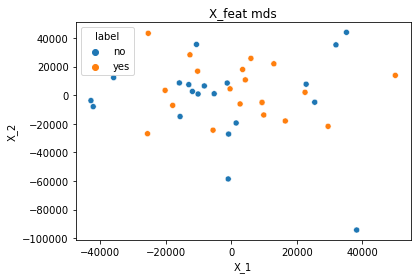

/Users/sadahiroyoshi/miniforge3/envs/torch-gpu/lib/python3.9/site-packages/sklearn/manifold/_mds.py:506: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


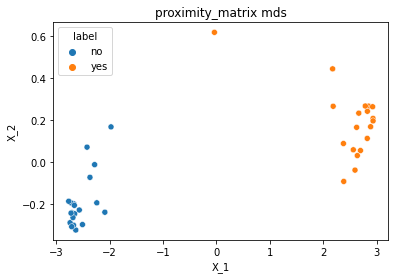

In [302]:
# 主成分抽出(mds)
mds = sklearn.manifold.MDS(n_components=2, random_state=seed)

plot_r2dim(mds, X_feat, y, names_by_label, 'X_feat mds')
plot_r2dim(mds, proximity_matrix, y, names_by_label, 'proximity_matrix mds')

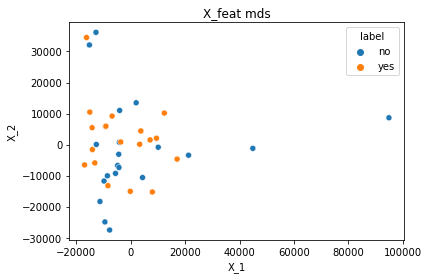

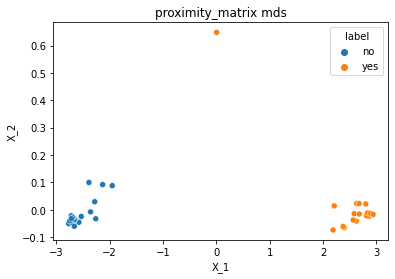

In [303]:
# 主成分抽出(PCA)
pca = sklearn.decomposition.PCA(n_components=2, random_state=seed)

plot_r2dim(pca, X_feat, y, names_by_label, 'X_feat pca')
plot_r2dim(pca, proximity_matrix, y, names_by_label, 'proximity_matrix pca')

### DecisionTreeClassifier

In [353]:
clf = sklearn.tree.DecisionTreeClassifier(random_state=seed, splitter="random")

scores = sklearn.model_selection.cross_val_score(clf, X_feat, y, cv=5)
print(scores)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

[0.875 0.75  0.875 1.    0.875]
score:0.875 (+/-0.158)


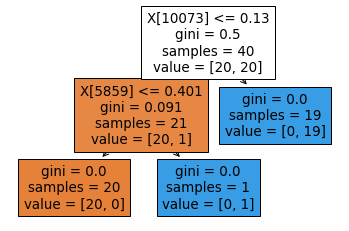

In [354]:
clf.fit(X_feat, y)

sklearn.tree.plot_tree(clf, filled=True)
plt.show()


データが簡単なので、わりと単純な決定木でも精度が出てしまう模様

### SVC

In [305]:
clf = sklearn.svm.SVC(random_state=seed)

scores = sklearn.model_selection.cross_val_score(clf, X_feat, y, cv=5)
print('score:{:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std()*2))

score:0.625 (+/-0.158)
